## Resumen del notebook

En este notebook se implementa una regresión logisitca para una clasficación binomial.

Ya que en el notebook anterior se obtuvo un modelo con resultados regulares,  en este notebook se pretende incrementar el numero de imagenes del set de entrenamiento y de prueba para tratar de mejorar los resultados del modelo ante imagenes de lentes gravitacionales reales. Ademas, se agregaron al dataset imagenes con "simulaciones" de lentes diferentes al modelo anterior para tratar de obtener un modelo con mayor capacidad de reconocimiento de estos objetos.


Al final del notebook se realiza una prueba del modelo entrenado con imagenes de lentes gravitacionales reales con forma de arco para analizar el desempeño ante estas imagenes. Los resultados detallados para cada modelo se encuentran mas adelante. 
 

**Información del data set utilizado:**

No. Imagenes **sin** lentes para TRAIN: 1700

No. Imagenes **con** lentes para TRAIN: 3783


No. Imagenes **sin** lentes para TEST: 1450

No. Imagenes **con** lentes para TEST: 2500


**Principales hiperparametros de entrenamiento en este notebook:**

Tamaño en pixeles de las imagenes de entrenamiento: 217x217x3 

Alpha (learning rate): 0.005

Numero de iteraciones durante el entrenamiento: 2000

**Desempeño de este modelo ante imagenes reales de lentes gravitacionales: MAL:** Realiza una mala clasificación en la mayoria de las imagenes reales. Se necesita mejorar el modelo en general y tratar de identificar por qué el rendimiento del modelo disminuyó. 

**Desempeño del modelo:**

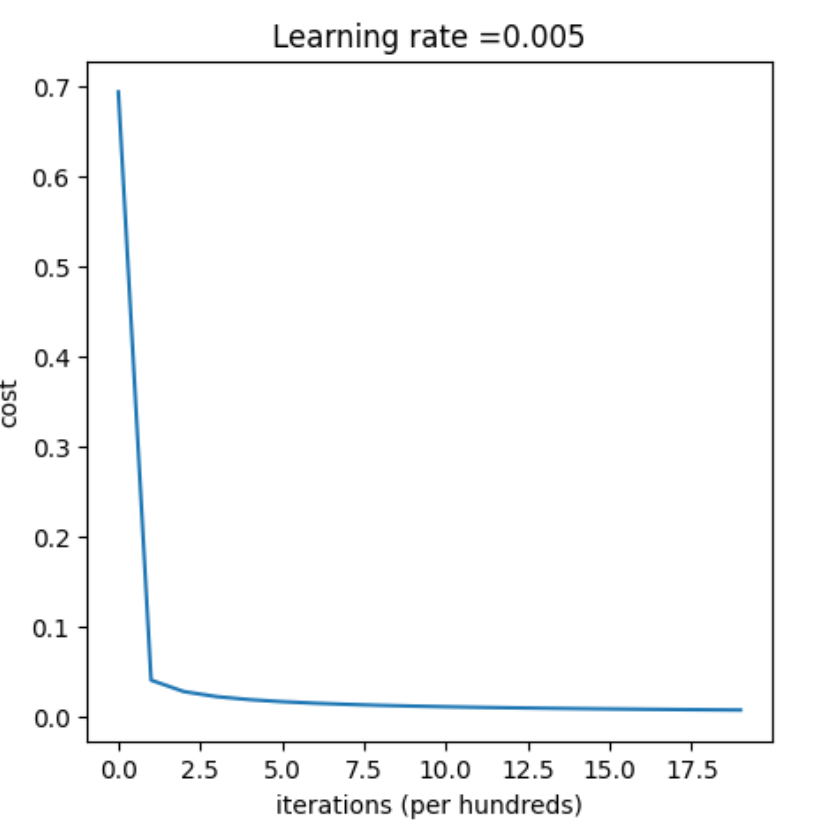

**Desempeño del modelo con diferentes valores de alpha (learning rate):**

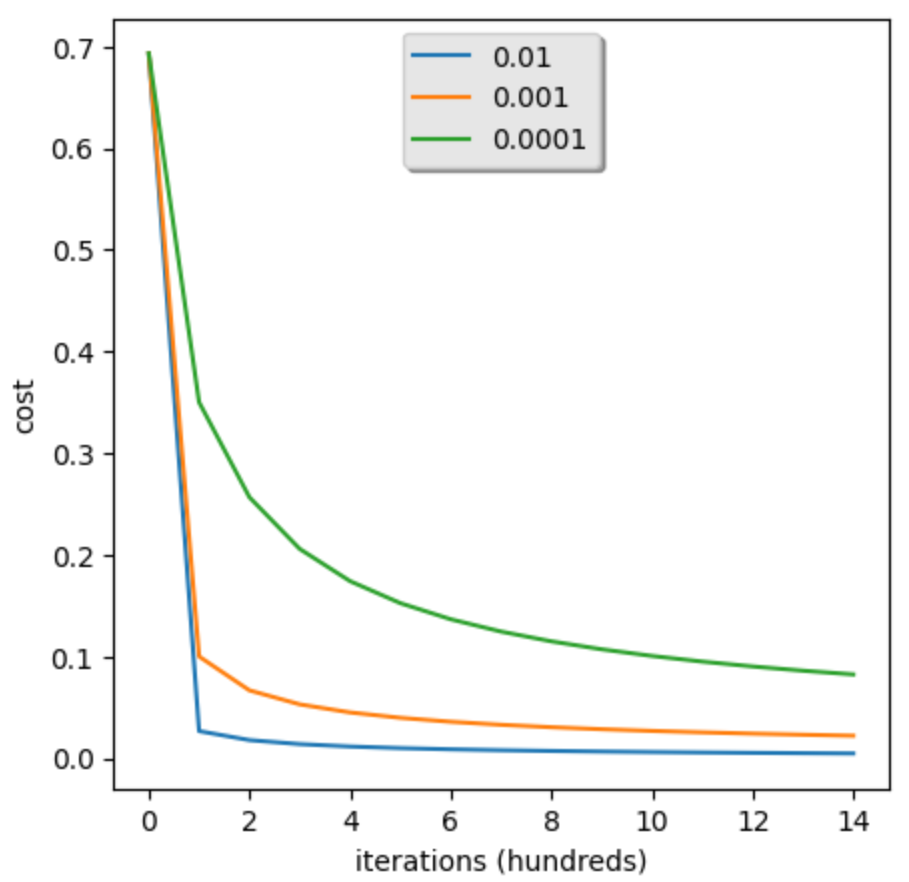

<a name='1'></a>
## Cargar librerias 

Primero cargamos las librerias necesarias para este notebook de clasificación binaria.

In [41]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from dnn_app_utils_v4 import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [40]:
#####
import tensorflow as tf
from astroNN.datasets import galaxy10
import sklearn
from sklearn.model_selection import train_test_split
#import scipy.ndimage
import cv2
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
import os
from scipy import ndimage

In [5]:
#tamaño de pixeles al que serán ajustadas las imagenes de entrenamiento y prueba
n_pixeles=94
dim = (n_pixeles, n_pixeles)

In [9]:
pwd

'/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W4_A2'

/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/
/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies_lens/
/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/
/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies_lens/


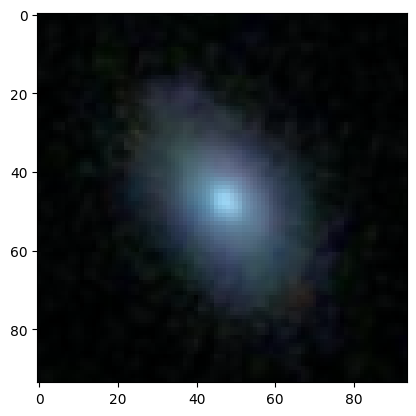

In [10]:
limite = 100000

# Crear un solo arreglo de todas las imagenes dentro de las carpeta TRAIN
image1 = cv2.imread('/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/0_Smooth, in-between round.png')
image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
image2 = cv2.imread('/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/1000_Disk, Face-on, No Spiral.png')
image2 = cv2.resize(image2, dim, interpolation = cv2.INTER_AREA) 


train_set_x_orig_2 = np.append(image1 , image1)
train_set_x_orig_2.shape

basepath = '/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/'
print(basepath)
i = 0
with os.scandir(basepath) as entries:
    for entry in entries:
        print(i, end="\r")
        if(i==limite):
            break
        if entry.is_file():
            #print(str(entry.name))
            if(i > 1):
                name = f'/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/' + str(entry.name)
                image1 = cv2.imread(name)
                image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
                imaget = train_set_x_orig_2
                train_set_x_orig_2 = np.append(imaget , image1)
        i = i+1

basepath2 = '/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies_lens/'
print(basepath2)
i = 0
with os.scandir(basepath2) as entries:
    for entry in entries:
        print(i, end="\r")
        if(i==limite):
            break
        if entry.is_file():
            #print(str(entry.name))
            name = f'/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies_lens/' + str(entry.name)
            image1 = cv2.imread(name)
            image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
            imaget = train_set_x_orig_2
            train_set_x_orig_2 = np.append(imaget , image1)
        i=i+1  

i = 0
p2 = train_set_x_orig_2.shape[0]/(n_pixeles*n_pixeles*3) 
r2 = int(p2)
plt.imshow(train_set_x_orig_2.reshape(r2, n_pixeles, n_pixeles, 3)[0])

# Crear un solo arreglo de todas las imagenes dentro de las carpeta TEST
image1 = cv2.imread('/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/0_Smooth, in-between round.png')
image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
image2 = cv2.imread('/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/1000_Disk, Edge-on, Rounded Bulge.png')
image2 = cv2.resize(image2, dim, interpolation = cv2.INTER_AREA) 

test_set_x_orig_2 = np.append(image1 , image1)
test_set_x_orig_2.shape

basepath = '/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/'
print(basepath)
i = 0
with os.scandir(basepath) as entries:
    for entry in entries:
        print(i, end="\r")
        if(i==limite):
            break
        if entry.is_file():
            #print(str(entry.name))
            if(i > 1):
                name = f'/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/' + str(entry.name)
                image1 = cv2.imread(name)
                image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
                imaget = test_set_x_orig_2
                test_set_x_orig_2 = np.append(imaget , image1)
        i = i+1   
        
basepath2 = '/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies_lens/'
print(basepath2)
i = 0
with os.scandir(basepath2) as entries:
    for entry in entries:
        print(i, end="\r")
        if(i==limite):
            break
        if entry.is_file():
            #print(str(entry.name))
            name = f'/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies_lens/' + str(entry.name)
            image1 = cv2.imread(name)
            image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
            imaget = test_set_x_orig_2
            test_set_x_orig_2 = np.append(imaget , image1)
        i=i+1
        
p = test_set_x_orig_2.shape[0]/(n_pixeles*n_pixeles*3) 
r = int(p)
plt.imshow(test_set_x_orig_2.reshape(r, n_pixeles, n_pixeles, 3)[1])

In [11]:
train = train_set_x_orig_2.reshape(r2, n_pixeles, n_pixeles, 3)
train.shape

(4600, 94, 94, 3)

In [17]:
# para train
d1 = 2199 # sin lentes
d2 = 2400 #con lentes

hola = np.zeros((1, d1 + 1)) 
bye = np.zeros((1, d2)) + 1
c = np.append(hola, bye)
c_train = c.reshape(1, d1+d2 +1)
c_train.shape

(1, 4600)

In [12]:
test = test_set_x_orig_2.reshape(r, n_pixeles, n_pixeles, 3)
test.shape

(3001, 94, 94, 3)

In [19]:
# para test
d1= 1501 #sin lentes
d2= 1500 #con lentes

hola = np.zeros((1, d1))
bye = np.zeros((1, d2)) + 1
c = np.append(hola, bye)
c_test = c.reshape(1, d1+d2)
c_test.shape

(1, 3001)

<a name='2'></a>
## 2 - Load and Process the Dataset

You'll be using the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you built back then had 70% test accuracy on classifying cat vs non-cat images. Hopefully, your new model will perform even better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of `m_train` images labelled as cat (1) or non-cat (0)
    - a test set of `m_test` images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [20]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [21]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [22]:
# Loading the data (LENS / NO_LENS)
classes2 = classes
classes2[0] = b'NO_LENS'
classes2[1] = b'LENS'


train_x_orig = train
train_y = c_train
test_x_orig = test
test_y = c_test
classes = classes2

In [23]:
train_x_orig.shape

(4600, 94, 94, 3)

In [24]:
train_y.shape

(1, 4600)

In [25]:
test_x_orig.shape

(3001, 94, 94, 3)

In [26]:
test_y.shape

(1, 3001)

In [27]:
classes[np.squeeze(train_y[:, 0].astype(int))].decode("utf-8")

'NO_LENS'

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to check out other images. 

y = 0.0. It's a NO_LENS picture.


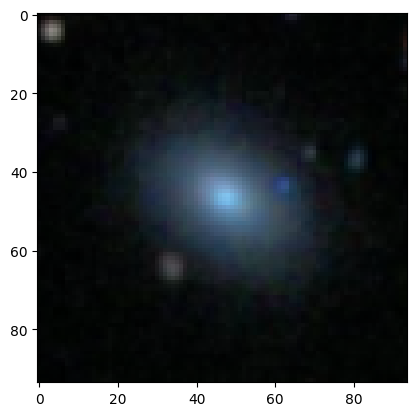

In [29]:
# Example of a picture
index = 100
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index].astype(int)].decode("utf-8") +  " picture.")

In [30]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 4600
Number of testing examples: 3001
Each image is of size: (94, 94, 3)
train_x_orig shape: (4600, 94, 94, 3)
train_y shape: (1, 4600)
test_x_orig shape: (3001, 94, 94, 3)
test_y shape: (1, 3001)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [31]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (26508, 4600)
test_x's shape: (26508, 3001)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

In [32]:
64*64*3

12288

In [33]:
n_pixeles*n_pixeles*3

26508

<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Now that you're familiar with the dataset, it's time to build a deep neural network to distinguish cat images from non-cat images!

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, you'll compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 3</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='3-3'></a>
### 3.3 - General Methodology

As usual, you'll follow the Deep Learning methodology to build the model:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

Now go ahead and implement those two models!

<a name='4'></a>
## 4 - Two-layer Neural Network

<a name='ex-1'></a>
### Exercise 1 - two_layer_model 

Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [34]:
### CONSTANTS DEFINING THE MODEL ####
n_x = n_pixeles*n_pixeles*3     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0085

In [67]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0085, num_iterations = 3500, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        # YOUR CODE STARTS HERE
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = 'sigmoid')
        
        # YOUR CODE ENDS HERE
        
        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(A2, Y)
        
        # YOUR CODE ENDS HERE
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        # YOUR CODE STARTS HERE
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [42]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6938038991712057
Cost after first iteration: 0.6939008013465494
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 2: 0.6524135179683452
 All tests passed.


**Expected output:**

```
cost after iteration 1 must be around 0.69
```

<a name='4-1'></a>
### 4.1 - Train the model 

If your code passed the previous cell, run the cell below to train your parameters. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

Cost after iteration 0: 0.6939008013465494
Cost after iteration 100: 0.6280570629047192
Cost after iteration 200: 0.12498869922208329
Cost after iteration 300: 0.04290455109525841
Cost after iteration 400: 0.025571350932569514
Cost after iteration 500: 0.018602822774435895
Cost after iteration 600: 0.014906921294745003
Cost after iteration 700: 0.012623465671787059
Cost after iteration 800: 0.011068131202735186
Cost after iteration 900: 0.009934283231543104
Cost after iteration 1000: 0.009065671118775485
Cost after iteration 1100: 0.008374014533824761
Cost after iteration 1200: 0.0078060745853612635
Cost after iteration 1300: 0.007328252864858429
Cost after iteration 1400: 0.006917758906392929
Cost after iteration 1500: 0.006559021811740771
Cost after iteration 1600: 0.006241261055142099
Cost after iteration 1700: 0.005956504817865234
Cost after iteration 1800: 0.005698491280384834
Cost after iteration 1900: 0.005462440059391735
Cost after iteration 2000: 0.0052447701492454426
Cost aft

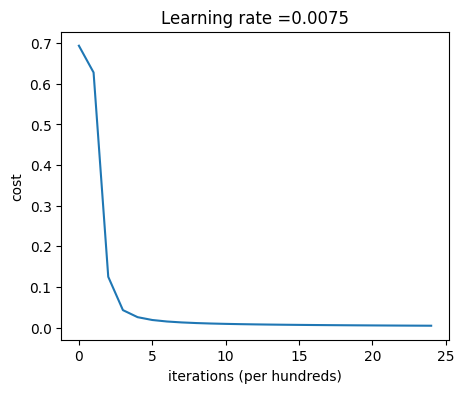

In [68]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.04421498215868956 </td>
    </tr>
</table>

**Nice!** You successfully trained the model. Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [69]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9991304347826088


**Expected Output**:
<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.9999999999999998 </td>
    </tr>
</table>

In [70]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.9100299900033321


**Expected Output**:

<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.72 </td>
    </tr>
</table>

In [71]:
# We preprocess the image to fit your algorithm.
def predecir(my_image): 
    ## START CODE HERE ##
    #my_image = "my_image.jpg" # change this to the name of your image file 
    my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
    ## END CODE HERE ##

    fname = "/home/luiscantero/Hola/Python/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/images/" + my_image
    image = np.array(Image.open(fname).resize((num_px, num_px)))
    plt.imshow(image)
    image = image / 255.
    image = image.reshape((1, num_px * num_px * 3)).T

    my_predicted_image = predict(image, my_label_y, parameters)

    print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


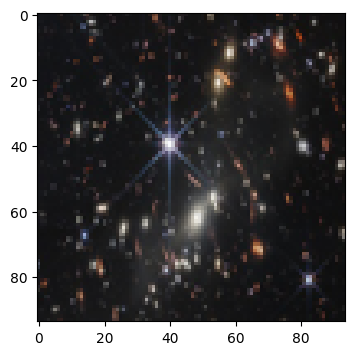

In [72]:
my_image = "smacs0723.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


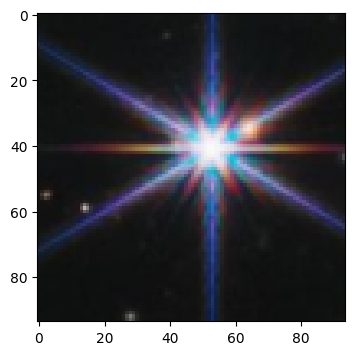

In [73]:
my_image = "lente_no_1.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


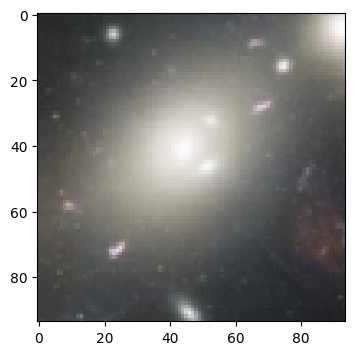

In [74]:
my_image = "lente_no_2.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


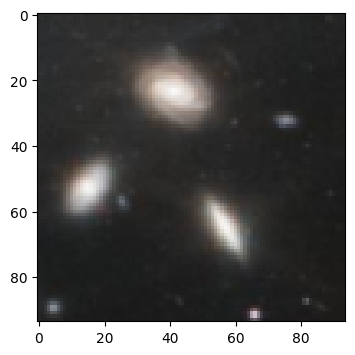

In [75]:
my_image = "lente_no_3.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


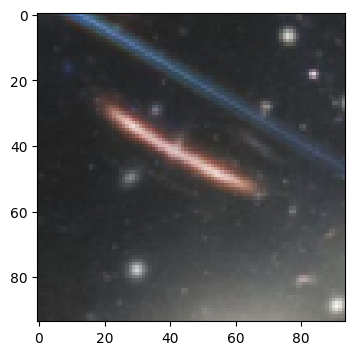

In [76]:
my_image = "lente_no_4.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


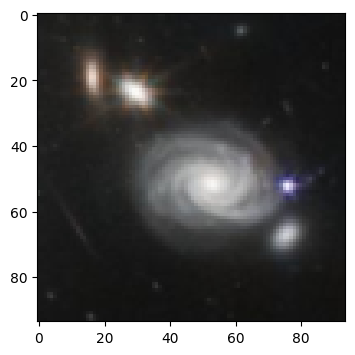

In [77]:
my_image = "lente_no_5.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


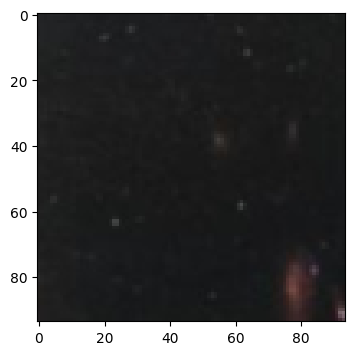

In [78]:
my_image = "lente_sino_1.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


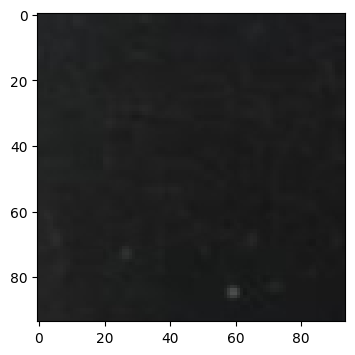

In [79]:
my_image = "lente_sino_2.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


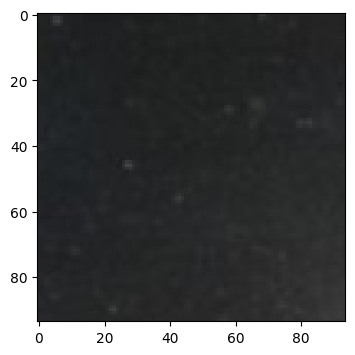

In [80]:
my_image = "lente_sino_3.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


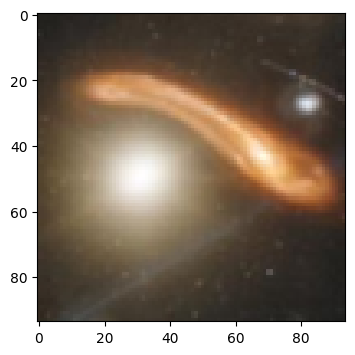

In [81]:
my_image = "lente_si_1.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


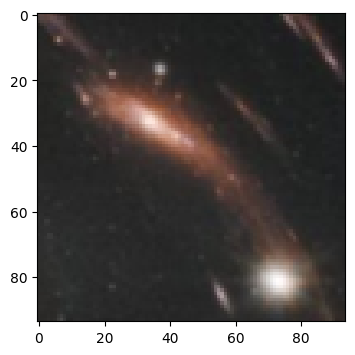

In [82]:
my_image = "lente_si_2.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


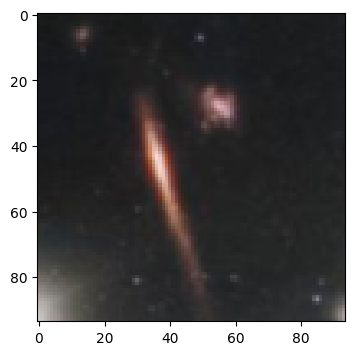

In [83]:
my_image = "lente_si_3.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


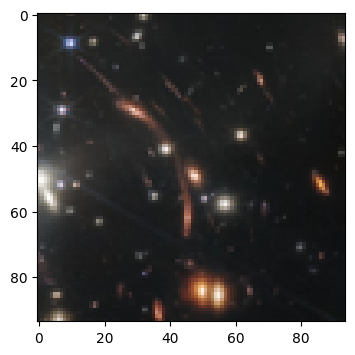

In [84]:
my_image = "lente_si_4.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


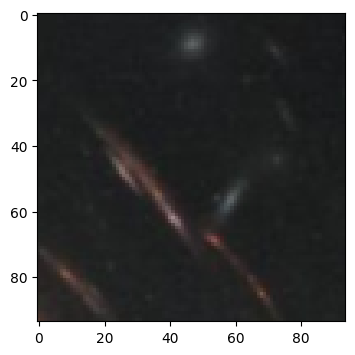

In [85]:
my_image = "lente_si_5.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


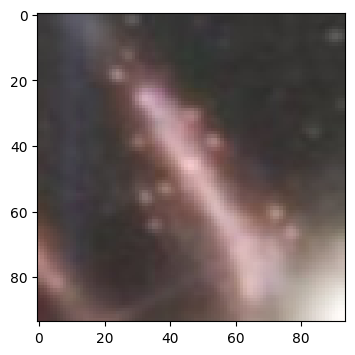

In [86]:
my_image = "lente_si_6.jpg"   
predecir(my_image)

### Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and you'll hear more about it in the next course. Early stopping is a way to prevent overfitting. 

<a name='5'></a>
## 5 - L-layer Neural Network

<a name='ex-2'></a>
### Exercise 2 - L_layer_model 

Use the helper functions you implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [88]:
### CONSTANTS ###
layers_dims = [n_pixeles*n_pixeles*3, 15, 7, 5, 1] #  4-layer model

In [87]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.008, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)
        
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL, Y)
        
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)
        
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [58]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

L_layer_model_test(L_layer_model)

Cost after iteration 0: 0.6889564395839339
Cost after first iteration: 0.6889564395839339
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 2: 0.7063462654190897
 All tests passed.


<a name='5-1'></a>
### 5.1 - Train the model 

If your code passed the previous cell, run the cell below to train your model as a 4-layer neural network. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

In [89]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 3500, print_cost = True)

Cost after iteration 0: 0.6957445158360601
Cost after iteration 100: 0.2843831807059946
Cost after iteration 200: 0.06733127586076439
Cost after iteration 300: 0.029167806536220732
Cost after iteration 400: 0.018183062161371364
Cost after iteration 500: 0.013411949415491163
Cost after iteration 600: 0.010806035703281303
Cost after iteration 700: 0.009153727089879342
Cost after iteration 800: 0.007994155972660517
Cost after iteration 900: 0.007120488618389206
Cost after iteration 1000: 0.006426560158178854
Cost after iteration 1100: 0.005854885859983708
Cost after iteration 1200: 0.005369891836407612
Cost after iteration 1300: 0.004949137649478105
Cost after iteration 1400: 0.004578495847666655
Cost after iteration 1500: 0.004248541468162643
Cost after iteration 1600: 0.00395270197633284
Cost after iteration 1700: 0.003686328940181736
Cost after iteration 1800: 0.003445247664917203
Cost after iteration 1900: 0.0032266352941152363
Cost after iteration 2000: 0.0030279801694490026
Cost aft

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.088439 </td>
    </tr>
</table>

In [90]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9997826086956523


**Expected Output**:

<table>
    <tr>
    <td>
        <b>Train Accuracy</b>
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [91]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.9133622125958012


**Expected Output**:

<table> 
    <tr>
        <td> <b>Test Accuracy</b></td>
        <td> 0.8 </td>
    </tr>
</table>

### Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is pretty good performance for this task. Nice job! 

In the next course on "Improving deep neural networks," you'll be able to obtain even higher accuracy by systematically searching for better hyperparameters: learning_rate, layers_dims, or num_iterations, for example.  

### Congratulations on finishing this assignment! 

You just built and trained a deep L-layer neural network, and applied it in order to distinguish cats from non-cats, a very serious and important task in deep learning. ;) 

By now, you've also completed all the assignments for Course 1 in the Deep Learning Specialization. Amazing work! If you'd like to test out how closely you resemble a cat yourself, there's an optional ungraded exercise below, where you can test your own image. 

Great work and hope to see you in the next course! 

<a name='7'></a>
## 7 - Test with your own image (optional/ungraded exercise) ##

From this point, if you so choose, you can use your own image to test  the output of your model. To do that follow these steps:

1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Change your image's name in the following code
4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


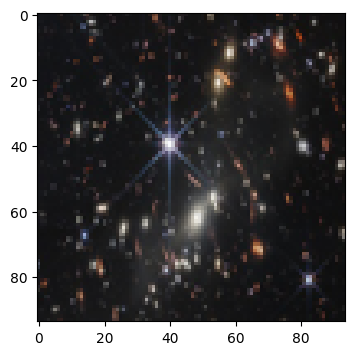

In [92]:
my_image = "smacs0723.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


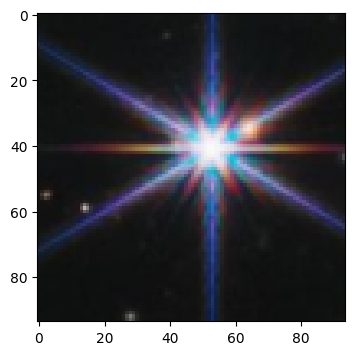

In [93]:
my_image = "lente_no_1.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


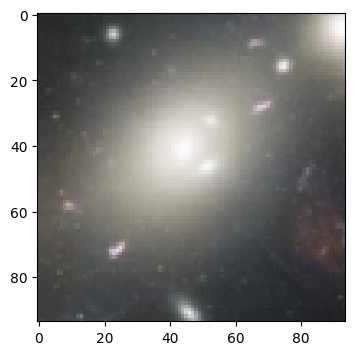

In [94]:
my_image = "lente_no_2.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


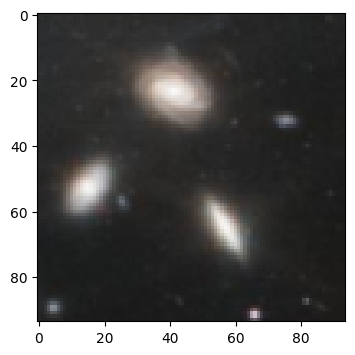

In [95]:
my_image = "lente_no_3.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


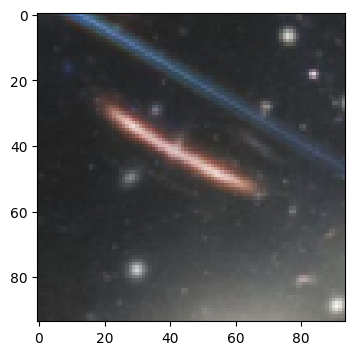

In [96]:
my_image = "lente_no_4.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


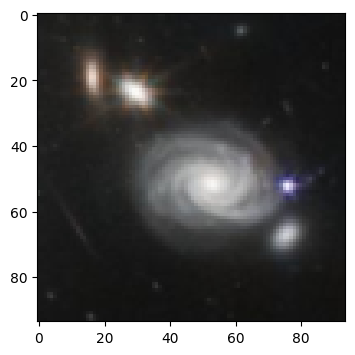

In [97]:
my_image = "lente_no_5.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


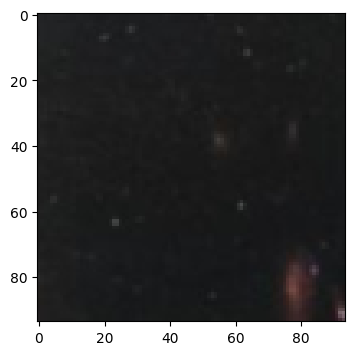

In [98]:
my_image = "lente_sino_1.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


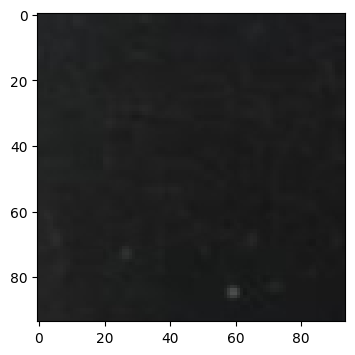

In [99]:
my_image = "lente_sino_2.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


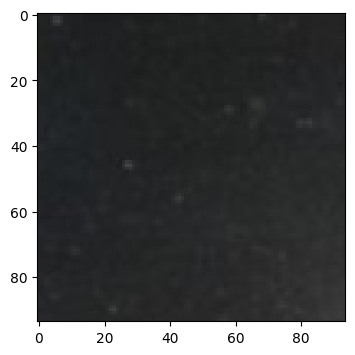

In [100]:
my_image = "lente_sino_3.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


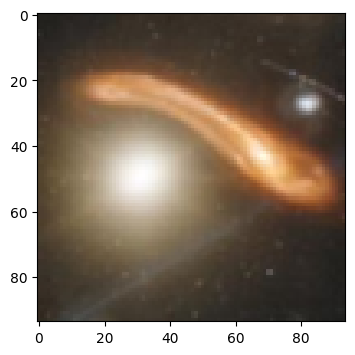

In [101]:
my_image = "lente_si_1.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


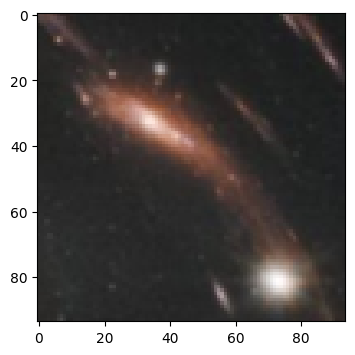

In [102]:
my_image = "lente_si_2.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


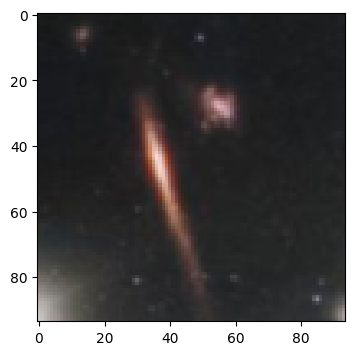

In [103]:
my_image = "lente_si_3.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


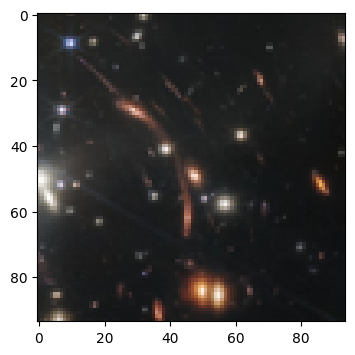

In [104]:
my_image = "lente_si_4.jpg"   
predecir(my_image)

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "LENS" picture.


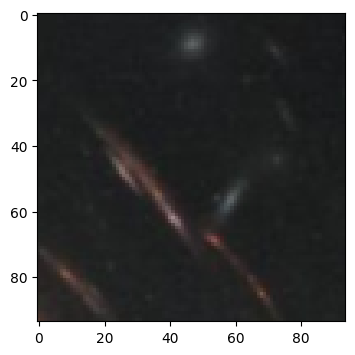

In [105]:
my_image = "lente_si_5.jpg"   
predecir(my_image)

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


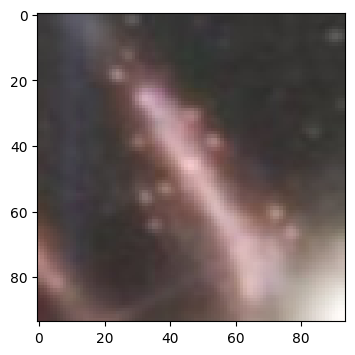

In [106]:
my_image = "lente_si_6.jpg"   
predecir(my_image)

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython